In [1]:
cd ..

/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1


In [2]:
import os
import sys
import pandas as pd
from srcs.utils.logger import get_module_logger

NOTEBOOK_DIR = os.getcwd() 
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../../"))  

# Add the project root to sys.path
sys.path.append(PROJECT_ROOT)

from srcs.utils.settings import (
    CLEANED_METADATA_PATH_CSV, CLEANED_REVIEWS_PATH_CSV, FULL_GRAPH_PATH,
    TRAIN_GRAPH_PATH, VAL_GRAPH_PATH, TEST_GRAPH_PATH
)


# Set up the logger
logger = get_module_logger("graph_builder")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

reviews_df = pd.read_csv(CLEANED_REVIEWS_PATH_CSV)
meta_df = pd.read_csv(CLEANED_METADATA_PATH_CSV)

In [4]:
reviews_df.head(5)

,user_id,parent_asin,rating,timestamp,year,month,day,hour,minute,recency,recency_weight
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0047T79VS,3.0,2012-08-08 06:08:03.000,2012,8,8,6,8,4650,0.000215
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01HHURN3W,3.0,2014-08-25 19:42:23.000,2014,8,25,19,42,3903,0.000256
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B017T99JPG,5.0,2016-02-29 18:59:25.000,2016,2,29,18,59,3350,0.000298
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01LW71IBJ,5.0,2016-02-29 19:02:51.000,2016,2,29,19,2,3350,0.000298
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B09S6Y5BRG,5.0,2018-11-04 18:40:31.659,2018,11,4,18,40,2371,0.000422


In [5]:
meta_df.head(5)

,main_category,title,average_rating,rating_number,price,store,parent_asin,n_features,n_description_items,first_image,brand,color,date_first_available,primary_category,rating_bin
0,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,19.99,Digi-Tatoo,B07SM135LS,5,0,https://m.media-amazon.com/images/I/31t4bj9t88...,Digi-Tatoo,Fresh Marble,2019-06-03,Electronics,Medium
1,Amazon Fashion,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,9.99,Notocity,B089CNGZCW,5,0,https://m.media-amazon.com/images/I/41j56fjX6S...,Unknown,Unknown,2020-05-29,Electronics,Medium
2,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,14.99,Verizon,B004E2Z88O,3,1,https://m.media-amazon.com/images/I/51-DXSMlHa...,Unknown,Unknown,2010-11-26,Electronics,Medium
3,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,14.89,Qghxo,B07BJ7ZZL7,5,10,https://m.media-amazon.com/images/I/51UefzXMzv...,Unknown,5Pcs Bands-Girl,2018-03-17,Electronics,Medium
4,Cell Phones & Accessories,May Chen Compatible with MacBook Pro 16 inch C...,4.5,649,26.99,May Chen,B0822SL7JX,5,1,https://m.media-amazon.com/images/I/51mR3hFRLs...,May Chen,Abstract Leaves,2023-02-06,Electronics,Medium


In [6]:
len(reviews_df), len(meta_df)

(13472190, 13513)

In [7]:
# Ensure both columns are strings
reviews_df['parent_asin'] = reviews_df['parent_asin'].astype(str)
meta_df['parent_asin'] = meta_df['parent_asin'].astype(str)

# Keep only reviews for products that exist in meta_df
filtered_reviews_df = reviews_df[reviews_df['parent_asin'].isin(meta_df['parent_asin'])].copy()

# Optional: Keep only meta entries that appear in reviews (not mandatory unless needed)
filtered_meta_df = meta_df[meta_df['parent_asin'].isin(filtered_reviews_df['parent_asin'])].copy()


In [8]:
print(f"Filtered reviews: {len(filtered_reviews_df):,}")
print(f"Unique products in reviews: {filtered_reviews_df['parent_asin'].nunique():,}")
print(f"Filtered meta products: {len(filtered_meta_df):,}")


Filtered reviews: 1,138,185
Unique products in reviews: 13,513
Filtered meta products: 13,513


# Build the Bipartite Graph of Users ↔ Products

In [9]:
filtered_reviews_df.columns, filtered_meta_df.columns

(Index(['user_id', 'parent_asin', 'rating', 'timestamp', 'year', 'month', 'day',
        'hour', 'minute', 'recency', 'recency_weight'],
       dtype='object'),
 Index(['main_category', 'title', 'average_rating', 'rating_number', 'price',
        'store', 'parent_asin', 'n_features', 'n_description_items',
        'first_image', 'brand', 'color', 'date_first_available',
        'primary_category', 'rating_bin'],
       dtype='object'))

In [10]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

# Encode users & items
user_enc = LabelEncoder()
item_enc = LabelEncoder()

filtered_reviews_df['user_idx'] = user_enc.fit_transform(filtered_reviews_df['user_id'])
filtered_reviews_df['item_idx'] = item_enc.fit_transform(filtered_reviews_df['parent_asin'])

num_users = len(user_enc.classes_)
num_items = len(item_enc.classes_)
num_nodes = num_users + num_items

print(f"Num users: {num_users}, Num items: {num_items}, Total nodes: {num_nodes}")

Num users: 742651, Num items: 13513, Total nodes: 756164


In [11]:
# Cell 2: Item Feature Tensor
item_features_df = filtered_meta_df.copy()
item_features_df['item_idx'] = item_enc.transform(item_features_df['parent_asin'])

num_cols = [
    'average_rating',
    'rating_number',
    'price',
    'n_features',
    'n_description_items'
]

item_feat_mat = (
    item_features_df
    .set_index('item_idx')[num_cols]
    .astype(float)
    .sort_index()
    .values
)

item_features_tensor = torch.from_numpy(item_feat_mat).float()
print("Item features shape:", item_features_tensor.shape)  # [num_items, 5]


Item features shape: torch.Size([13513, 5])


In [12]:
# Cell 3: User Feature Tensor
user_stats = (
    filtered_reviews_df
    .groupby('user_id')
    .agg(
        avg_rating_given=('rating','mean'),
        review_count=('rating','count'),
        mean_recency_weight=('recency_weight','mean')
    )
    .fillna(0)
)

user_features_df = (
    user_stats
    .reindex(user_enc.classes_)
    .fillna(0)
)

user_feat_mat = user_features_df.values.astype(float)
user_features_tensor = torch.from_numpy(user_feat_mat).float()
print("User features shape:", user_features_tensor.shape)  # [num_users, 3]


User features shape: torch.Size([742651, 3])


In [13]:
# Cell 4: Align Feature Dimensions and Combine
# Pad user features with zeros for the two extra dimensions
zeros_padding = torch.zeros((num_users, item_features_tensor.size(1) - user_features_tensor.size(1)))
user_padded = torch.cat([user_features_tensor, zeros_padding], dim=1)

# Combine
x = torch.cat([user_padded, item_features_tensor], dim=0)
assert x.size(0) == num_nodes
print("Combined node feature matrix shape:", x.shape)  # [num_nodes, 5]


Combined node feature matrix shape: torch.Size([756164, 5])


In [14]:
# Cell 5: Build edge_index and edge_attr
src = torch.tensor(filtered_reviews_df['user_idx'].values, dtype=torch.long)
dst = torch.tensor(filtered_reviews_df['item_idx'].values + num_users, dtype=torch.long)
edge_index = torch.stack([src, dst], dim=0)

edge_attr = torch.tensor(
    filtered_reviews_df[['rating','recency_weight']].values.astype(float),
    dtype=torch.float
)

print("Edge index shape:", edge_index.shape)
print("Edge attr shape:", edge_attr.shape)


Edge index shape: torch.Size([2, 1138185])
Edge attr shape: torch.Size([1138185, 2])


In [15]:
# Cell 6: Pack into PyG Data
from torch_geometric.data import Data

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(graph)
print(graph.x)
print(graph.edge_index)
print(graph.edge_attr)


Data(x=[756164, 5], edge_index=[2, 1138185], edge_attr=[1138185, 2])
tensor([[5.0000e+00, 1.0000e+00, 2.7027e-04, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 2.0000e+00, 3.5907e-04, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 1.0000e+00, 9.0744e-04, 0.0000e+00, 0.0000e+00],
        ...,
        [4.4000e+00, 8.7000e+01, 3.4900e+02, 5.0000e+00, 0.0000e+00],
        [4.7000e+00, 4.9170e+03, 1.1990e+01, 5.0000e+00, 0.0000e+00],
        [5.0000e+00, 4.0000e+00, 1.1990e+01, 5.0000e+00, 1.5000e+01]])
tensor([[413732, 332183,  67130,  ...,  82190,  82190, 619548],
        [750430, 744494, 750817,  ..., 752527, 752934, 754028]])
tensor([[5.0000e+00, 3.2862e-04],
        [5.0000e+00, 3.0694e-04],
        [5.0000e+00, 4.5537e-04],
        ...,
        [4.0000e+00, 1.5408e-03],
        [4.0000e+00, 1.6529e-03],
        [5.0000e+00, 1.6529e-03]])


In [16]:
import torch

torch.save(graph, FULL_GRAPH_PATH)
print("Graph saved to 'storex_graph.pt'")

Graph saved to 'storex_graph.pt'


In [17]:
# Applying RandomLinkSplit to split the graph
from torch_geometric.transforms import RandomLinkSplit

# Define the transform
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,         # Amazon graph should be treated as undirected
    add_negative_train_samples=True,
    edge_types=('edge_index',),  # optional, here for clarity
    rev_edge_types=None
)

# Apply the transform
train_data, val_data, test_data = transform(graph)

# Print the results
print("Train data:", train_data)
print("Val data:", val_data)
print("Test data:", test_data)

# Save the splits
torch.save(train_data, TRAIN_GRAPH_PATH)
torch.save(val_data, VAL_GRAPH_PATH)
torch.save(test_data, TEST_GRAPH_PATH)


Train data: Data(x=[756164, 5], edge_index=[2, 1934916], edge_attr=[1934916, 2], edge_label=[1934916], edge_label_index=[2, 1934916])
Val data: Data(x=[756164, 5], edge_index=[2, 1934916], edge_attr=[1934916, 2], edge_label=[113818], edge_label_index=[2, 113818])
Test data: Data(x=[756164, 5], edge_index=[2, 2048734], edge_attr=[2048734, 2], edge_label=[227636], edge_label_index=[2, 227636])


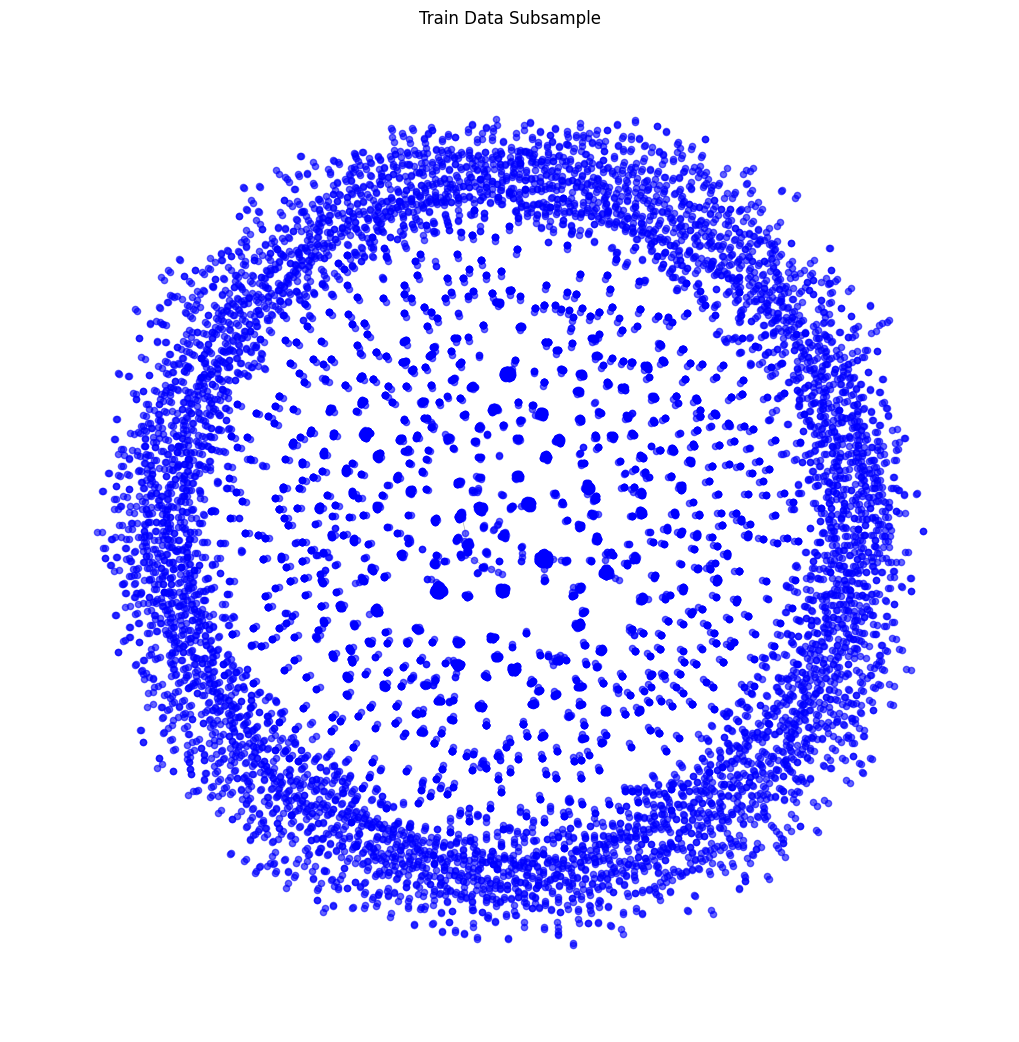

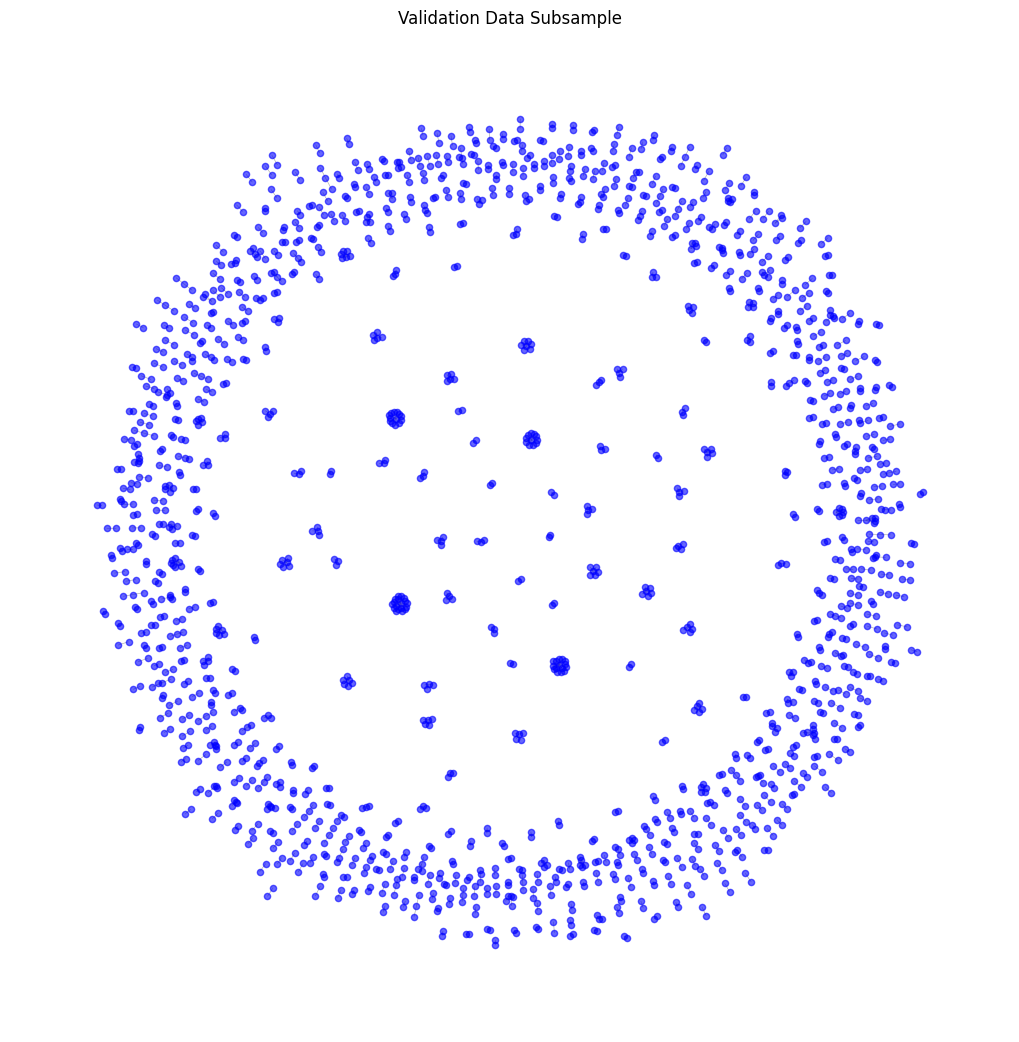

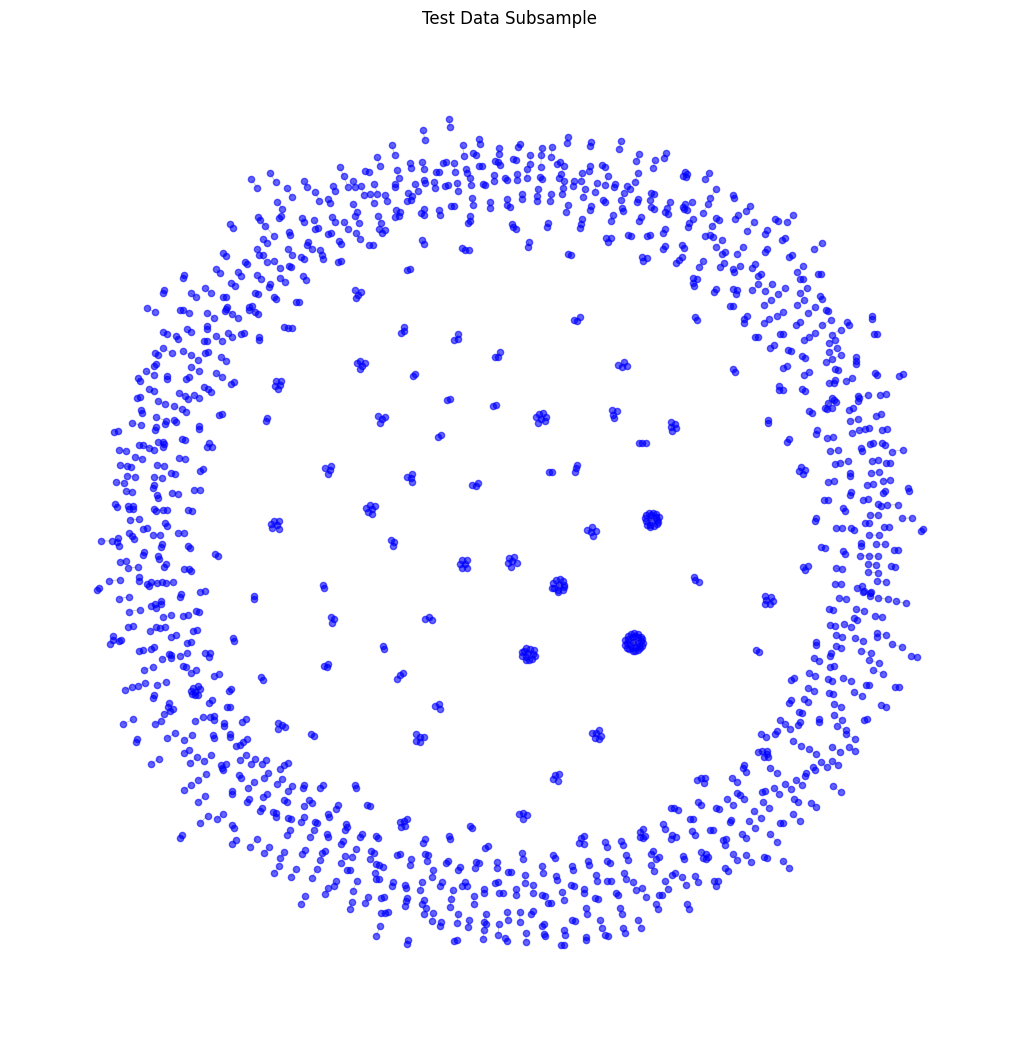

In [22]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph_with_edges(edge_index, title="Graph"):
    # Convert edge_index to a networkx graph
    G = nx.Graph()
    edges = edge_index.numpy().T
    G.add_edges_from(edges)
    
    # Visualize the graph using networkx
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  # Layout the nodes
    nx.draw(G, pos, with_labels=False, node_size=20, node_color="blue", alpha=0.6, edge_color="gray", width=0.5)
    plt.title(title)
    plt.show()

# Randomly sample a subset of the edge_index from train, val, and test data
train_sample_edge_index = train_data.edge_index[:, torch.randperm(train_data.edge_index.size(1))[:10000]]  # Sample 500 edges
val_sample_edge_index = val_data.edge_index[:, torch.randperm(val_data.edge_index.size(1))[:1000]]  # Sample 500 edges
test_sample_edge_index = test_data.edge_index[:, torch.randperm(test_data.edge_index.size(1))[:1000]]  # Sample 500 edges

# Visualize each sample
visualize_graph_with_edges(train_sample_edge_index, title="Train Data Subsample")
visualize_graph_with_edges(val_sample_edge_index, title="Validation Data Subsample")
visualize_graph_with_edges(test_sample_edge_index, title="Test Data Subsample")
